# Modelado

EXTRATEGIA QUE SE HA DECIDIDO SEGUIR:

In [ ]:
# Librerías básicas
import numpy as np
import pandas as pd
import os
import joblib

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métodos de validación y ajuste de modelos
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Modelos de regresión
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LinearRegression

# SHAP para explicación de modelos
import shap
shap.initjs()

# Importación de módulos personalizados
from modulos.data_description import *
from modulos.data_model import *
from modulos.data_visualization import *

# Configuración de pandas
pd.set_option('display.max_columns', None)

## 1. Carga del Dataset

In [2]:
# Cargamos el dataset internal_transformed
ruta_binario = os.path.join('data', 'internal_transformed.pkl')
internal_transformed = joblib.load(ruta_binario)

# Eliminamos la variable 'Credit_Score' para que no esté duplicada
internal_transformed.drop(columns='Credit_Score', inplace=True)

In [3]:
# Cargamos el dataset external_transformed
ruta_binario = os.path.join('data', 'external_transformed.pkl')
external_transformed = joblib.load(ruta_binario)

### Unión ambos Dataset

In [4]:
df = pd.merge(internal_transformed, external_transformed, on=['PROSPECTID'], how='inner')

### División del Dataset

In [5]:
# Separamos variable dependiente de las independientes
X = df.drop(columns=['Credit_Score', 'PROSPECTID'], inplace=False)
Y = df['Credit_Score']

# Generamos el dataset de entrenamiento y el de test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=29, shuffle=True)

## 2. Regresión Lineal

### 2.1. OLS

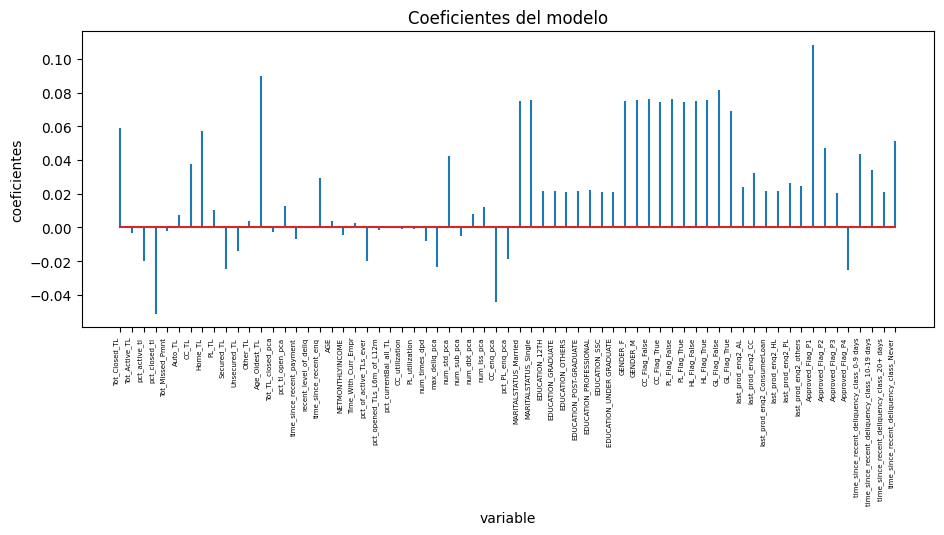

In [28]:
OLS = LinearRegression(fit_intercept=False)
OLS.fit(X_train, y_train)

df_coeficientes = pd.DataFrame(
    {'Predictor': X_train.columns,
     'Coef': OLS.coef_.flatten()}
    )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.Predictor, df_coeficientes.Coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [29]:
y_pred = OLS.predict(X_test).flatten()
rmse_ols = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 0.026975110051273073


In [12]:
def seleccionar_alpha_optimo(rmse_cv, rmse_sd, alphas):
    """ Selecciona el alpha óptimo usando la regla del mínimo + 1 desviación estándar. """
    min_rmse = np.min(rmse_cv)
    sd_min_rmse = rmse_sd[np.argmin(rmse_cv)]
    min_rmse_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
    optimo = alphas[np.argmin(rmse_cv)]
    optimo_1sd = alphas[rmse_cv == min_rmse_1sd][0]
    return optimo, optimo_1sd

### 2.2. Ridge

In [13]:
modelo_ridge = RidgeCV(
    alphas=np.logspace(-3, 10, 200), 
    store_cv_values=True, 
    fit_intercept=False).fit(X_train, y_train)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


(np.float64(0.000223872113856834),
 np.float64(44668359215.09635),
 np.float64(-0.05909234757802006),
 np.float64(0.11629296923753787))

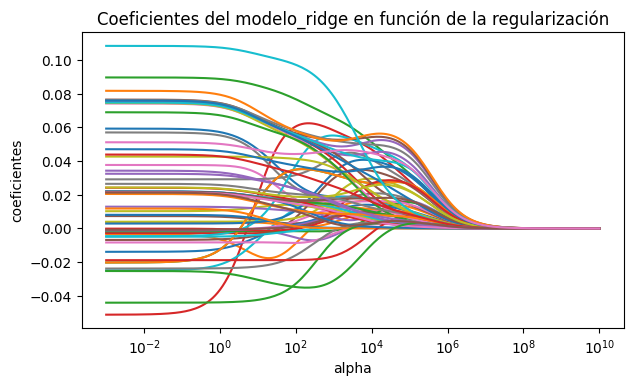

In [14]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_ridge.alphas
coefs = []

for alpha in alphas:
    modelo_ridge_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_ridge_temp.fit(X_train, y_train)
    coefs.append(modelo_ridge_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo_ridge en función de la regularización')
plt.axis('tight')

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


Mejor valor de alpha encontrado: 0.10595601792776159
Mejor valor de alpha encontrado + 1 desviación estándar: 37834.62617131933


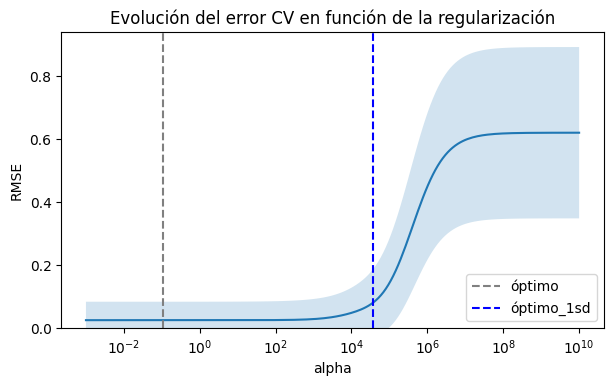

In [15]:
mse_cv = modelo_ridge.cv_values_.mean(axis=0)
mse_sd = modelo_ridge.cv_values_.std(axis=0)
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)
optimo_ridge, optimo_ridge_1sd = seleccionar_alpha_optimo(rmse_cv, rmse_sd, modelo_ridge.alphas)

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo_ridge.alphas, rmse_cv)
ax.fill_between(
    modelo_ridge.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo_ridge,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_ridge_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()
print(f"Mejor valor de alpha encontrado: {modelo_ridge.alpha_}")
print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_ridge_1sd}")

In [16]:
modelo_ridge_final = Ridge(alpha=optimo_ridge_1sd, fit_intercept=False).fit(X_train, y_train)
y_pred_ridge = modelo_ridge_final.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE Ridge: {rmse_ridge}")

RMSE Ridge: 0.08256464262034496


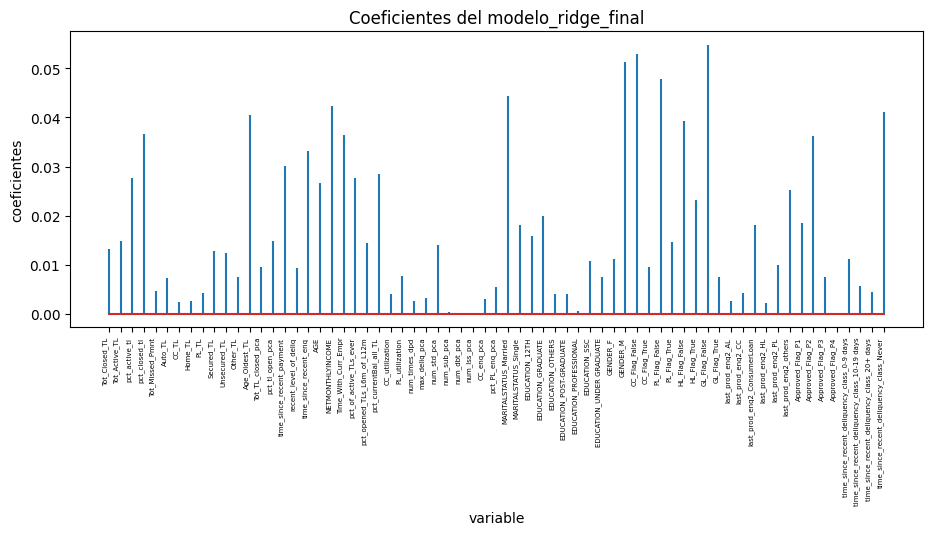

In [17]:
# Coeficientes del modelo_ridge_final
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_ridge_final.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo_ridge_final');

### 2.3. Lasso

In [18]:

modelo_lasso = LassoCV(
    alphas=np.logspace(-7, 3, 200), 
    cv=5,
    fit_intercept=False).fit(X_train, y_train)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5478305903440592, tolerance: 1.2612243057692962
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.510631764542792, tolerance: 1.2612243057692962
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e+00, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.242e+00, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8

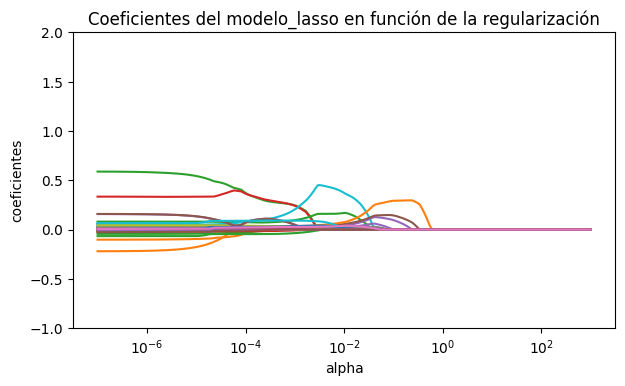

In [19]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_lasso.alphas_
coefs = []

for alpha in alphas:
    modelo_lasso_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_lasso_temp.fit(X_train, y_train)
    coefs.append(modelo_lasso_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-1,2])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo_lasso en función de la regularización');

Mejor valor de alpha encontrado: 1e-07
Mejor valor de alpha encontrado + 1 desviación estándar: 0.00148202070579886


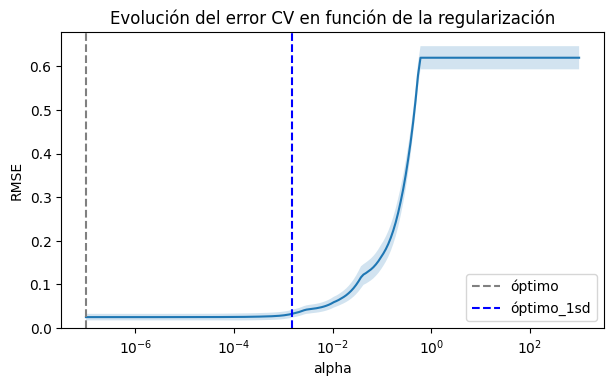

In [20]:
mse_cv = modelo_lasso.mse_path_.mean(axis=1)
mse_sd = modelo_lasso.mse_path_.std(axis=1)
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)
optimo_lasso, optimo_lasso_1sd = seleccionar_alpha_optimo(rmse_cv, rmse_sd, modelo_lasso.alphas_)



# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo_lasso.alphas_, rmse_cv)
ax.fill_between(
    modelo_lasso.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo_lasso,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_lasso_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()
print(f"Mejor valor de alpha encontrado: {modelo_lasso.alpha_}")
print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_lasso_1sd}")

In [21]:
modelo_lasso_final = Lasso(alpha=optimo_lasso_1sd, fit_intercept=False).fit(X_train, y_train)
y_pred_lasso = modelo_lasso_final.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE Lasso: {rmse_lasso}")

RMSE Lasso: 0.03458016340766251


In [22]:
# Coeficientes del modelo_lasso_final
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_lasso_final.coef_.flatten()}
                  )

# Predictores incluidos en el modelo_lasso_final (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
2,pct_active_tl,0.204151
3,pct_closed_tl,0.194994
12,Age_Oldest_TL,0.111568
17,time_since_recent_enq,0.037211
19,NETMONTHLYINCOME,0.270991
20,Time_With_Curr_Empr,0.013171
21,pct_of_active_TLs_ever,0.000485
23,pct_currentBal_all_TL,0.007453
28,num_std_pca,0.021244
33,pct_PL_enq_pca,-0.003974


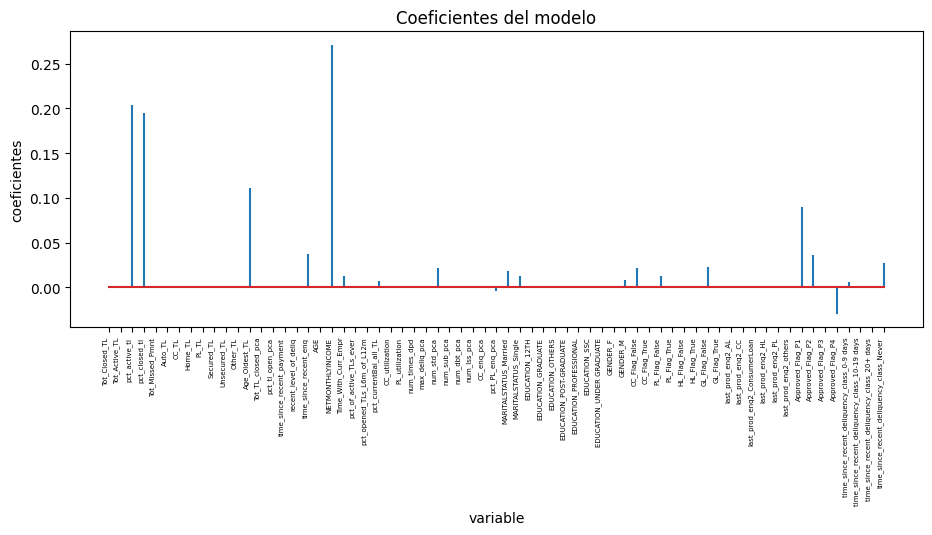

In [23]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

### 2.4. Elastic Net

In [24]:
# ElasticNetCV - Ajuste y selección de alpha óptimo
modelo_elastic = ElasticNetCV(
    l1_ratio=[0, 0.1, 0.4, 0.5, 0.7, 0.9, 0.99], 
    alphas=np.logspace(-8, 3, 200), 
    cv=5, 
    fit_intercept=False).fit(X_train, y_train)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6247.707163787179, tolerance: 1.2612243057692962
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWar

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.421e+01, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.421e+01, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8

(np.float64(2.8183829312644493e-09),
 np.float64(3548.133892335753),
 np.float64(-0.26092555645521837),
 np.float64(0.6292995391866371))

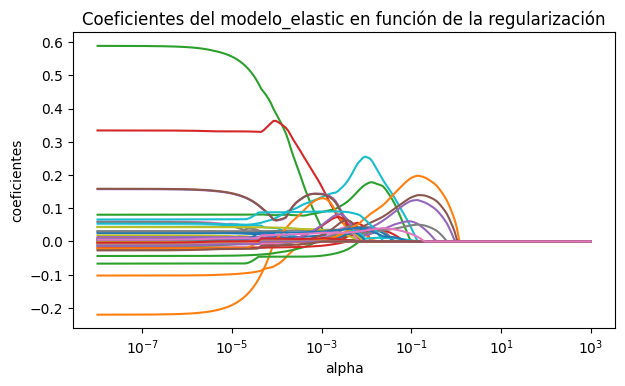

In [25]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_elastic.alphas
coefs = []

for alpha in alphas:
    modelo_elastic_temp = ElasticNet(alpha=alpha, fit_intercept=False)
    modelo_elastic_temp.fit(X_train, y_train)
    coefs.append(modelo_elastic_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo_elastic en función de la regularización')
plt.axis('tight')

In [26]:
mse_cv = modelo_elastic.mse_path_.mean(axis=2)
mse_sd = modelo_elastic.mse_path_.std(axis=2)
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)

best_l1_idx, best_alpha_idx = np.unravel_index(np.argmin(rmse_cv), rmse_cv.shape)
optimo_elastic, optimo_elastic_1sd = seleccionar_alpha_optimo(
    rmse_cv[best_l1_idx, :], rmse_sd[best_l1_idx, :], modelo_elastic.alphas_)

In [27]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo_elastic.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo_elastic.l1_ratio, modelo_elastic.alphas_],
                                    names     = ['l1_ratio', 'modelo_elastic.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo_elastic.alphas_,mse_cv,rmse_cv
575,0.4,2.121452e-07,0.000636,0.025228
776,0.5,1.867914e-07,0.000636,0.025228
777,0.5,1.644676e-07,0.000636,0.025228
979,0.7,1.275051e-07,0.000636,0.025228
1181,0.9,9.884959e-08,0.000636,0.025228
...,...,...,...,...
649,0.5,1.956398e+00,0.383779,0.619499
650,0.5,1.722586e+00,0.383779,0.619499
651,0.5,1.516717e+00,0.383779,0.619499
652,0.5,1.335452e+00,0.383779,0.619499


In [28]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo_elastic.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo_elastic.l1_ratio_}")

Mejor valor de alpha encontrado: 2.1214517849106278e-07
Mejor valor de l1_ratio encontrado: 0.4


In [29]:
modelo_elastic_final = ElasticNet(alpha=optimo_elastic_1sd, fit_intercept=False).fit(X_train, y_train)
y_pred_elastic = modelo_elastic_final.predict(X_test)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
print(f"RMSE Elastic Net: {rmse_elastic}")

RMSE Elastic Net: 0.036228931372460166


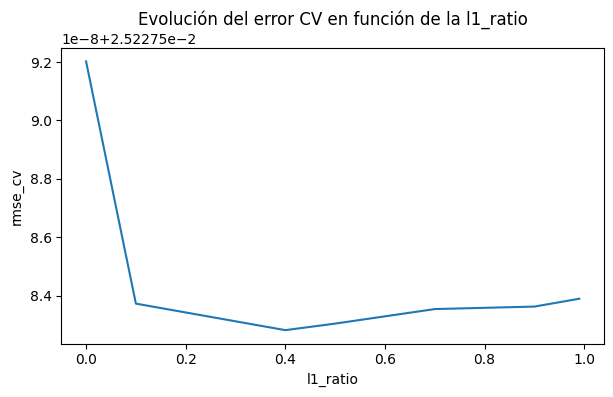

In [30]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [31]:
# Coeficientes del modelo_elastic_final
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_elastic_final.coef_.flatten()}
                  )
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
2,pct_active_tl,0.024254
3,pct_closed_tl,0.048885
12,Age_Oldest_TL,0.127639
17,time_since_recent_enq,0.039110
19,NETMONTHLYINCOME,0.195082
20,Time_With_Curr_Empr,0.023616
21,pct_of_active_TLs_ever,0.031549
23,pct_currentBal_all_TL,0.016785
28,num_std_pca,0.014743
34,MARITALSTATUS_Married,0.040214


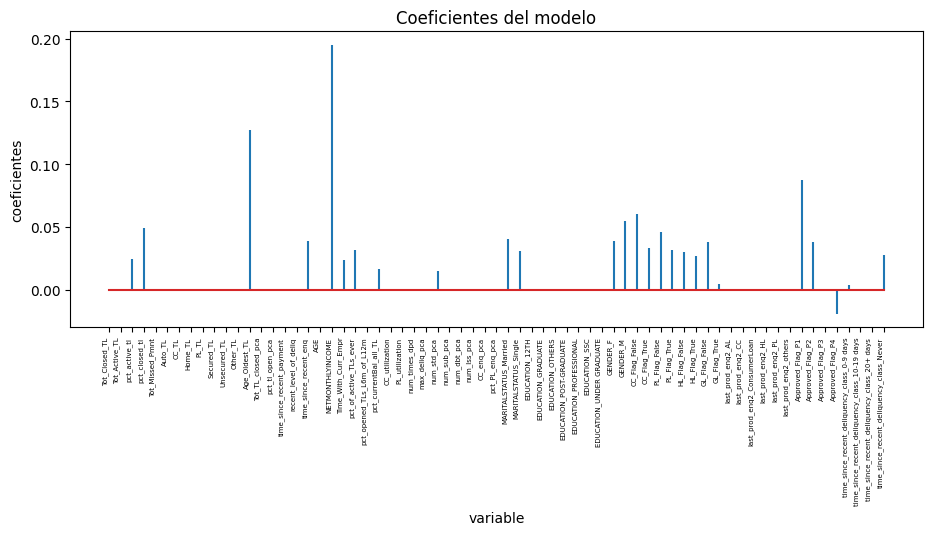

In [32]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

### 2.5. Comparación

Text(0.5, 1.0, 'Comparación de modelos')

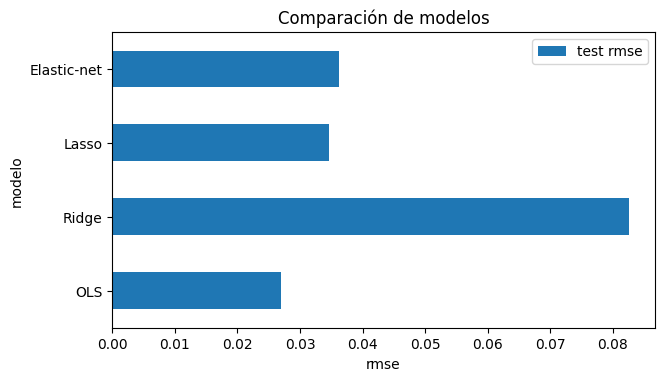

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos')

## 3. Regresión Lineal 

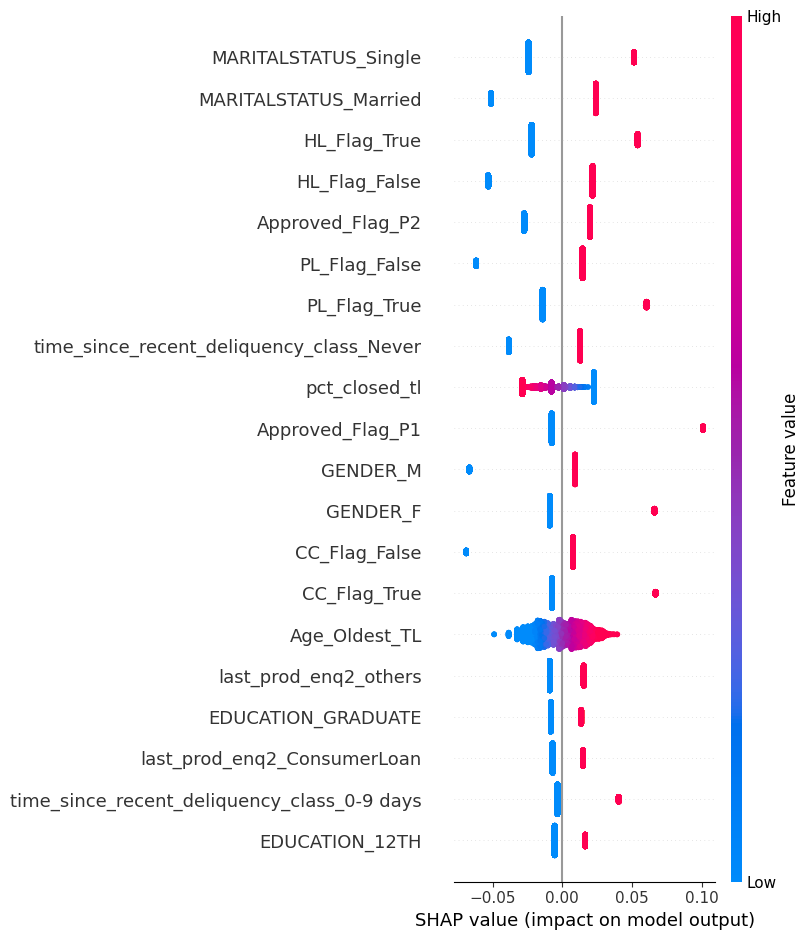

In [ ]:
# Crear el explicador de SHAP para el mejor modelo de regresión lineal
explainer = shap.LinearExplainer(OLS, X_train)

# Obtener los valores SHAP para todo el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Visualizar la importancia de las características
shap.summary_plot(shap_values, X_test)

In [42]:
# Usar shap.sample para reducir el número de muestras de fondo
background_data = shap.sample(X_train, 100)

# Crear el explicador de SHAP con el conjunto reducido de muestras
explainer = shap.LinearExplainer(OLS, background_data)

# Obtener los valores SHAP para la primera muestra de X_test (solo la primera muestra)
shap_values = explainer.shap_values(X_test.iloc[0:1, :])

# Visualizar los valores SHAP para la primera muestra
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :])

In [39]:
# Obtener la predicción del modelo para la misma muestra
prediccion = OLS.predict([X_test.iloc[0, :]])[0]

# Obtener el valor real de la muestra
valor_real = y_test.iloc[0]

# Mostrar la comparación
print(f"Predicción del modelo: {prediccion}")
print(f"Valor real: {valor_real}")

Predicción del modelo: 0.7231145856503134
Valor real: 0.7222222222222223


C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [41]:
# Calcular RMSE y R² en el conjunto de prueba
predicciones_test = OLS.predict(X_test)
mse_ols = mean_squared_error(y_test, predicciones_test)
rmse_ols = np.sqrt(mse_ols)
r2_ols = r2_score(y_test, predicciones_test)

# Imprimir las métricas
print(f"RMSE: {rmse_ols}")
print(f"R²: {r2_ols}")

RMSE: 0.026975110051273073
R²: 0.8063080395963419


## 4. K-Nearest Neighbours (KNN)

In [ ]:
# Definir el rango de valores de k a evaluar
param_grid = {'n_neighbors': range(1, 30)}

# Crear el modelo kNN para regresión
knn = KNeighborsRegressor()

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=5, 
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Minimizar el error
    n_jobs=-1
)

# Ajustar el modelo en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor valor de k
best_k = grid_search.best_params_['n_neighbors']
print(f"Mejor valor de k: {best_k}")

Mejor valor de k: 16


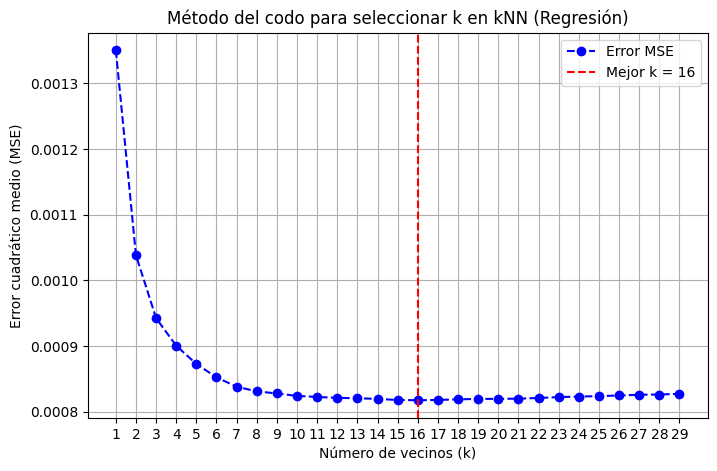

In [ ]:
# Obtener la evolución del error en función de k
k_values = param_grid['n_neighbors']
errors = -grid_search.cv_results_['mean_test_score']  # Convertir de negativo a positivo

# Graficar la evolución del error (Método del Codo)
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o', linestyle='dashed', color='b', label="Error MSE")
plt.axvline(best_k, linestyle="--", color="r", label=f"Mejor k = {best_k}")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Método del codo para seleccionar k en kNN (Regresión)")
plt.xticks(k_values)
plt.legend()
plt.grid()

# EXPLICAR QUE NO SE PUEDE HACER SHAP.SUMMARIZE.PLOT PORQUE REQUIERE TIEMPO DE COMPUTO

In [ ]:
# Obtener el mejor modelo entrenado tras la búsqueda de hiperparámetros
best_knn = grid_search.best_estimator_

# Usando shap.sample para reducir el número de muestras de fondo
background_data = shap.sample(X_train, 100)

# Crear el explicador de SHAP con el conjunto reducido de muestras
explainer = shap.KernelExplainer(best_knn.predict, background_data)

# Obtener los valores SHAP para la primera muestra de X_test
shap_values = explainer.shap_values(X_test.iloc[0:1, :])

# Visualizar los valores SHAP
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[0, :])

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
# Obtener la predicción del modelo para la misma muestra
prediccion = best_knn.predict([X_test.iloc[0, :]])[0]

# Obtener el valor real de la muestra
valor_real = y_test.iloc[0]

# Mostrar la comparación
print(f"Predicción del modelo: {prediccion}")
print(f"Valor real: {valor_real}")

Predicción del modelo: 0.7129020467836258
Valor real: 0.7222222222222223


C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [21]:
# Calcular RMSE y R² en el conjunto de prueba
predicciones_test = best_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, predicciones_test)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, predicciones_test)

# Imprimir las métricas
print(f"RMSE: {rmse_knn}")
print(f"R²: {r2_knn}")

RMSE: 0.0302047923874413
R²: 0.7571507009080386
